# <center><b> Práctica 2 de Laboratorio 5 </b><br><u> Espectroscopía Láser </u></center>

Grupo 1: Trinidad Borrel, Bruno Sivilotti, Agustín Brusco

In [115]:
import pyvisa as visa
import numpy as np
import matplotlib.pyplot as plt
import time
# Formato para matplotlib
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'
rcParams['axes.xmargin'] = 0
rcParams['axes.grid'] = True

# Formato para los gráficos:
MARKER_FMT = dict(markersize=6, markeredgewidth=0.25, markeredgecolor='k',)
ERROR_FMT = dict(ecolor='k', capsize=2,)

from instrumental import TDS1002B
try:
    rm.close()
except NameError:
    pass
rm = visa.ResourceManager()

instruments = rm.list_resources()
print(instruments)

for inst in instruments:
    if ('C065089::0::INSTR' in inst
        or 'C108013::0::INSTR' in inst):  # Ojo si nos cambian el osciloscopio
        print('Osciloscopio TDS1002B detectado:',
            f'\nID: {inst}')
        osci = TDS1002B(inst)
        
    elif 'M00404166::0::INSTR' in inst:
        print('Laser Diode Temperature Controller detectado:',
            f'\nID: {inst}')
        laser_diode = visa.ResourceManager().open_resource(inst)
        print(laser_diode.query('*IDN?'))

('USB0::4883::32842::M00404166::0::INSTR',)
Laser Diode Temperature Controller detectado: 
ID: USB0::4883::32842::M00404166::0::INSTR
Thorlabs,ITC4001,M00404166,1.8.0/1.5.0/2.3.0



In [88]:
def get_PID_state():
    global laser_diode
    P = laser_diode.query_ascii_values(
        "SOURce2:TEMPerature:LCONstants:GAIN?")
    I = laser_diode.query_ascii_values(
        "SOURce2:TEMPerature:LCONstants:INTegral?")
    D = laser_diode.query_ascii_values(
        "SOURce2:TEMPerature:LCONstants:DERivative?")
    period = laser_diode.query_ascii_values(
        "SOURce2:TEMPerature:LCONstants:PERiod?")
    return P + I + D + period

def set_PID_state(P=None, I=None, D=None, period=None):
    global laser_diode
    if P is not None:
        laser_diode.write(
            f"SOURce2:TEMPerature:LCONstants:GAIN {float(P)}")
    if I is not None:
        laser_diode.write(
            f"SOURce2:TEMPerature:LCONstants:INTegral {float(I)}")
    if D is not None:
        laser_diode.write(
            f"SOURce2:TEMPerature:LCONstants:DERivative {float(D)}")
    if period is not None:
        laser_diode.write(
            f"SOURce2:TEMPerature:LCONstants:PERiod {float(period)}")
    return None

In [114]:
set_PID_state(P=10, I=0.5, D=50)

In [110]:
temps = []
times = []
pid_state = get_PID_state()
print(f"P: {pid_state[0]}\t I: {pid_state[1]}\t D: {pid_state[2]}\t period: {pid_state[3]}")
temp_setpoint = 23
laser_diode.write(f"SOURce2:TEMPerature:SPOint {temp_setpoint}")
print(f"Temperature Setpoint: {temp_setpoint} °C")
laser_diode.write('MEASure[:SCALar]:TEMPerature?')

%matplotlib qt5
fig = plt.figure(tight_layout=True)
ax = plt.subplot()
ax.set_xlabel(r'$t \mathrm{\quad [s]}$')
ax.set_ylabel(r'$T \mathrm{\quad [^{\circ}C]}$')
start = time.time()
i = 0
try:
    while True:
        laser_diode.write('READ?')
        temps += laser_diode.query_ascii_values('FETCh:TEMPerature?')
        times.append(time.time() - start)  # s
        ax.plot(times, np.array(temps) - temp_setpoint, '.-',
            c='steelblue', mew=1, mec='k')
        plt.pause(0.5)
        i += 1
except KeyboardInterrupt:
    plt.show()
    print(f"Number of Measurements: {len(temps)}")

P: 10.0	 I: 0.5	 D: 25.0	 period: 20.0
Temperature Setpoint: 23 °C
Number of Measurements: 496


In [111]:
times = np.array(times)
temps = np.array(temps)
pid_state = np.array(pid_state)

In [112]:
def save_temp_data(times, temps, pid_state, setpoint, file_tag=None):
    if file_tag is None or file_tag == '':
        raise ValueError('Especificar `setpoint`.')
    data = np.array([times, temps],)
    state_data = np.concatenate([pid_state, [setpoint]],)
    np.save(f"TempData{file_tag}.npy", data, )
    np.save(f"TempState{file_tag}.npy", state_data, )
    return None

tag = input("File tag")
save_temp_data(times, temps, pid_state, temp_setpoint, tag)

In [113]:
for i in range(0, 8):
    print(np.load(f"TempState{i}.npy"))

[10.   0.5 50.  20.  21. ]
[10.   0.5 50.  20.  23. ]
[10.  1. 50. 20. 21.]
[10.  1. 50. 20. 23.]
[10.   0.5 25.  20.  21. ]
[20.   0.5 50.  20.  23. ]
[20.   0.5 50.  20.  21. ]
[10.   0.5 25.  20.  23. ]


In [45]:
FREQS_RUBIDIO85 = [361.78e6, 3.0357324390e9, 150.659e9+377.1073085690e12-1.2648885163e9, 150.659e9+377.1073085690e12, 377.1073085690e12-210.923e6- 1.2648885163e9, 377.1073085690e12-210.923e6+1.7708439228e9]
FREQS_RUBIDIO85.append(150.659e9+377.1073085690e12-1.2648885163e9+FREQS_RUBIDIO85[1])
FREQS_RUBIDIO85 = np.sort(FREQS_RUBIDIO85, )

FREQS_RUBIDIO87 = [814.5e6, 377.1052058e12, 388.1120405e12, 377.1043913e12, 377.111226e12, 6.834682610904290e9]   # Hz
FREQS_RUBIDIO87 = np.sort(FREQS_RUBIDIO87, )

def plot_channels(
    tiempo: np.ndarray, channel1: np.ndarray, channel2: np.ndarray, volt_scale="V"
) -> None:
    scale_dict = {
        "V": 1e0,
        "mV": 1e3,
    }

    plt.figure()
    plt.plot(
        tiempo * 1e3,
        channel1 * scale_dict[volt_scale],
        "^-",
        **MARKER_FMT,
        alpha=0.5,
        label="CH1"
    )
    plt.plot(
        tiempo * 1e3,
        channel2 * scale_dict[volt_scale],
        ".-",
        **MARKER_FMT,
        alpha=0.5,
        label="CH2"
    )
    plt.legend()
    plt.xlabel("$\mathrm{Tiempo}\quad\mathrm{[ms]}$")
    plt.ylabel("$\mathrm{Voltaje}\quad\mathrm{[" + volt_scale + "]}$")


    # plt.figure()
    # plt.scatter(
    #     channel1 * scale_dict[volt_scale],
    #     channel2 * scale_dict[volt_scale],
    #     s=7 * (1 - tiempo / tiempo[-1]),
    #     c=tiempo,
    #     linewidths=0.45,
    #     edgecolors="k",
    #     zorder=10,
    # )
    # plt.xlabel("$\mathrm{Canal\ 1}\quad\mathrm{[" + volt_scale + "]}$")
    # plt.ylabel("$\mathrm{Canal\ 2}\quad\mathrm{[" + volt_scale + "]}$")


def atenuar_db(Vin: float, dB: float) -> float:
    '''Devuelve el voltaje de salida correspondiente a atenuar
    una señal de voltaje `Vin` con un atenuador de `dB` decibeles.
    
    Devuelve `Vout` : `float` (en las mismas unidades que `Vin`)
    '''
    return 10**(np.log10(Vin) - dB/20)


def save_osci_data(t, *channels, filename=None):
    if filename is None:
        raise ValueError('Especificar `filename`.')
    osci_data = np.array([t, *channels],)
    np.save(filename, osci_data, )
    return None

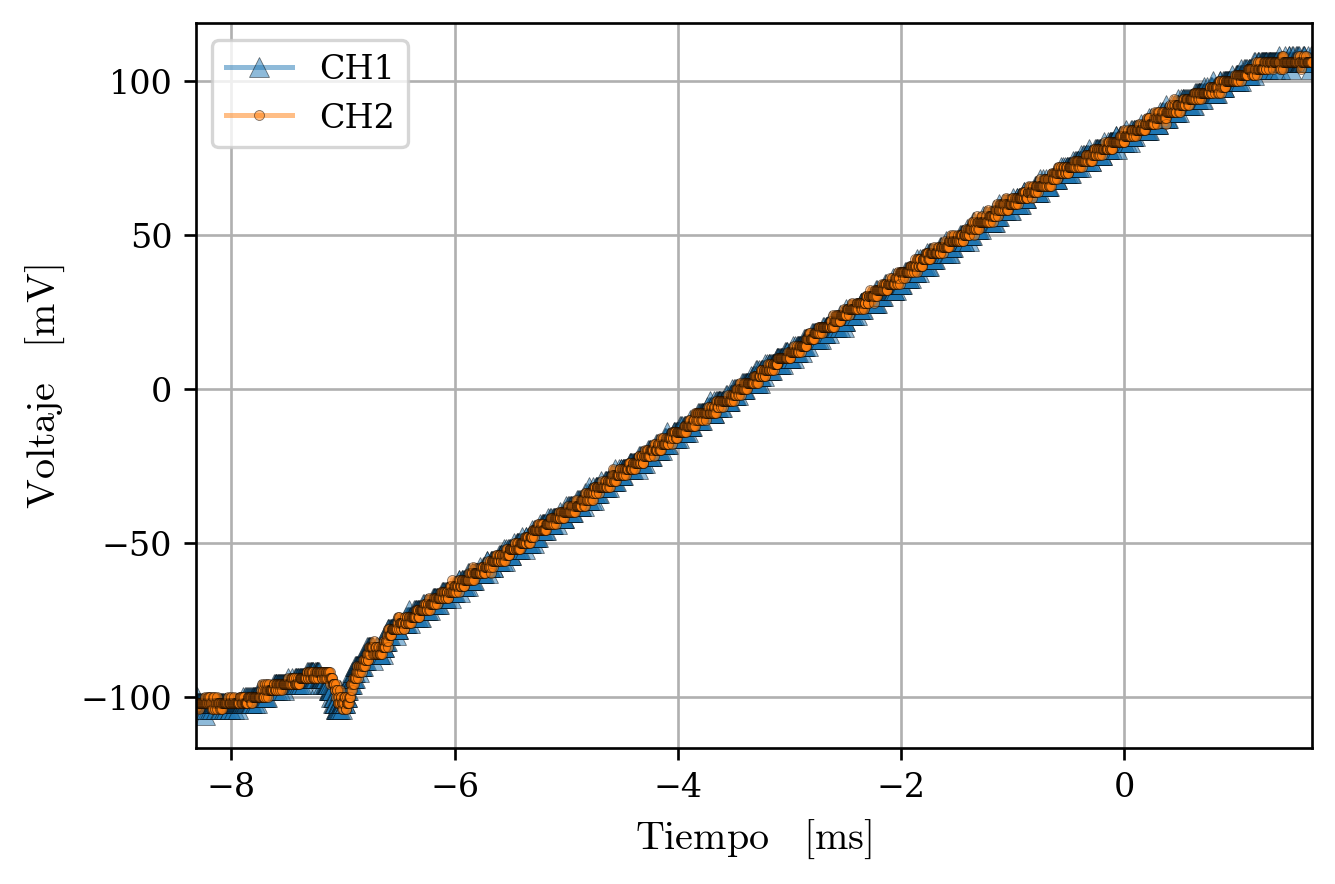

In [11]:

tiempo, channel1 = osci.read_data(0)  # s, V
tiempo, channel2 = osci.read_data(1)  # s, V

plot_channels(tiempo, channel1, channel2, 'mV')
# plt.xlim(-3.3, -1.9)
plt.show()

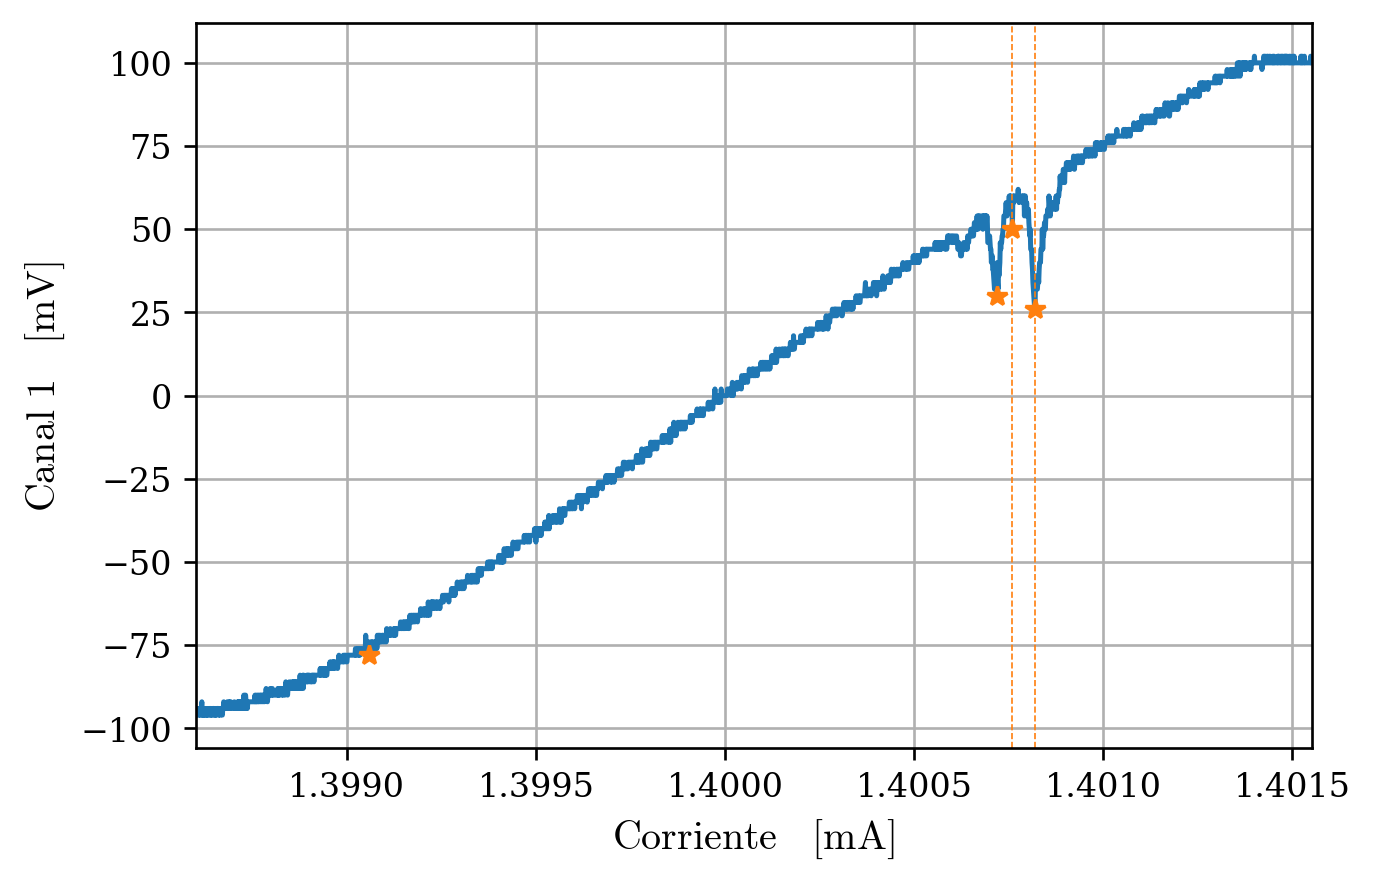

In [29]:
# from scipy.signal import sawtooth
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# def triangular(t, frecuencia, amplitud, fase, offset):
#     return amplitud*sawtooth(t*frecuencia*2*np.pi + fase, width=0.5) + offset

def lineal(t, a, b):
    return a*t + b

amp_scale = 'mA'
volt_scale = 'mV'
SCALE = {'V': 1e0, 'mV': 1e3, 'A': 1e0, 'mA': 1e3, 'MHz': 1e-6, 'GHz': 1e-9, 'THz': 1e-12}
# popt, pcov = curve_fit(triangular, tiempo, channel1, p0=[50, 0.1, 0.7, 200])

# Hipotesis: los picos de tensión se asocian a los picos de corriente
corriente_setpoint = 1.4e-3  # A : Valor medio de las oscilaciones
corriente_depth = 0.1/100
corriente_max = corriente_setpoint*(1+corriente_depth)  # A
corriente_min = corriente_setpoint*(1-corriente_depth)  # A
Temperatura = 22.5  # °C : fija
corriente_rango = corriente_max - corriente_min  # A
t_max = tiempo[np.argmax(channel1)]  # s
t_min = tiempo[np.argmin(channel1)]  # s
m = (corriente_max - corriente_min)/(t_max - t_min)  # A/s

corriente1 = m*(tiempo - t_min) + corriente_min  # A
popt, pcov = curve_fit(lineal, corriente1, channel1)

peaks = find_peaks(-(channel1 - lineal(corriente1, *popt)), distance=15, prominence=0.01)[0]


plt.figure()

plt.plot(corriente1*SCALE[amp_scale], channel1*SCALE[volt_scale])
plt.plot(corriente1[peaks]*SCALE[amp_scale], channel1[peaks]*SCALE[volt_scale], '*')
plt.axvline(corriente1[peaks[-2]]*SCALE[amp_scale], c='C1', lw=0.5, ls='--')
plt.axvline(corriente1[peaks[-1]]*SCALE[amp_scale], c='C1', lw=0.5, ls='--')
plt.ylabel("$\mathrm{Canal\ 1}\quad\mathrm{[" + volt_scale + "]}$")
plt.xlabel('$\mathrm{Corriente}\quad\mathrm{['+ amp_scale +']}$')
plt.show()


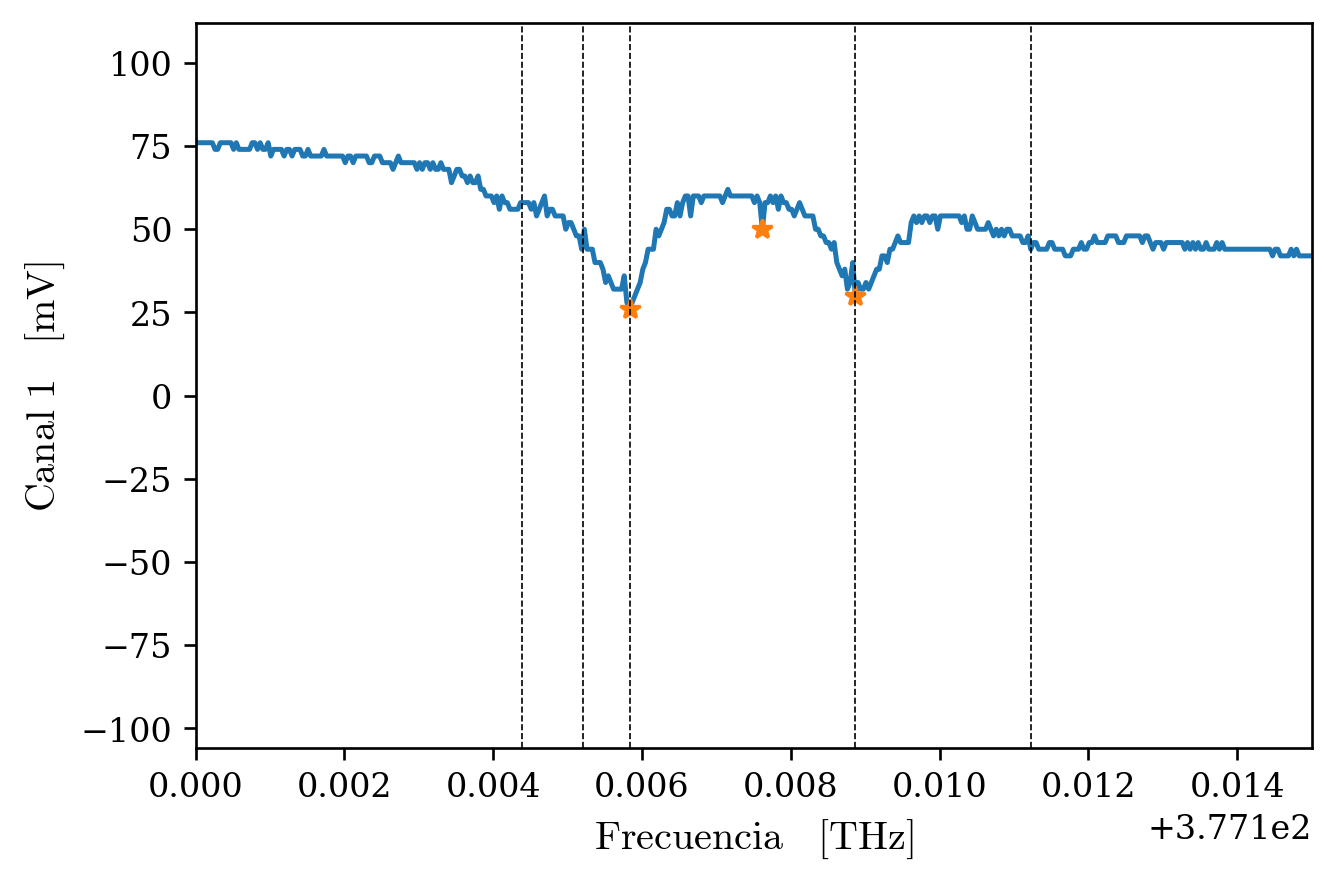

In [30]:
def corriente_a_frecuencia(corriente, freq_ru, corriente_forzada):
    m = -(freq_ru.max() - freq_ru.min())/(corriente_forzada.max() - corriente_forzada.min())
    return m*(corriente - corriente_forzada.min()) + freq_ru.max()

picos_forzados = corriente1[peaks[[-3, -1]]]  # A
freqs_rubidio = np.sort(np.concatenate([FREQS_RUBIDIO85, FREQS_RUBIDIO87]))  # Hz

# for idx1 in range(4, 8):
#     for idx2 in range(idx1+1, 9):
idx1 = 6
idx2 = 7
frecuencias = corriente_a_frecuencia(corriente1, freqs_rubidio[[idx1, idx2]], picos_forzados)
plt.figure()
hertz_scale = 'THz'

plt.plot(frecuencias*SCALE[hertz_scale], channel1*SCALE[volt_scale])
plt.plot(frecuencias[peaks]*SCALE[hertz_scale], channel1[peaks]*SCALE[volt_scale], '*')
for linea in freqs_rubidio:
    plt.axvline(linea*SCALE[hertz_scale], c='k', lw=0.5, ls='--')

plt.ylabel("$\mathrm{Canal\ 1}\quad\mathrm{[" + volt_scale + "]}$")
plt.xlabel('$\mathrm{Frecuencia}\quad\mathrm{['+ hertz_scale +']}$')
# plt.xlim(frecuencias.min()*scale_dict[hertz_scale], frecuencias.max()*scale_dict[hertz_scale])
plt.xlim(377.10, 377.115)
plt.grid(False)
plt.show()

    # freqs_rubidio*scale_dict['MHz']


In [164]:
freqs_rubidio[[6, 7]]*SCALE['THz']

array([377.10583276, 377.10886849])

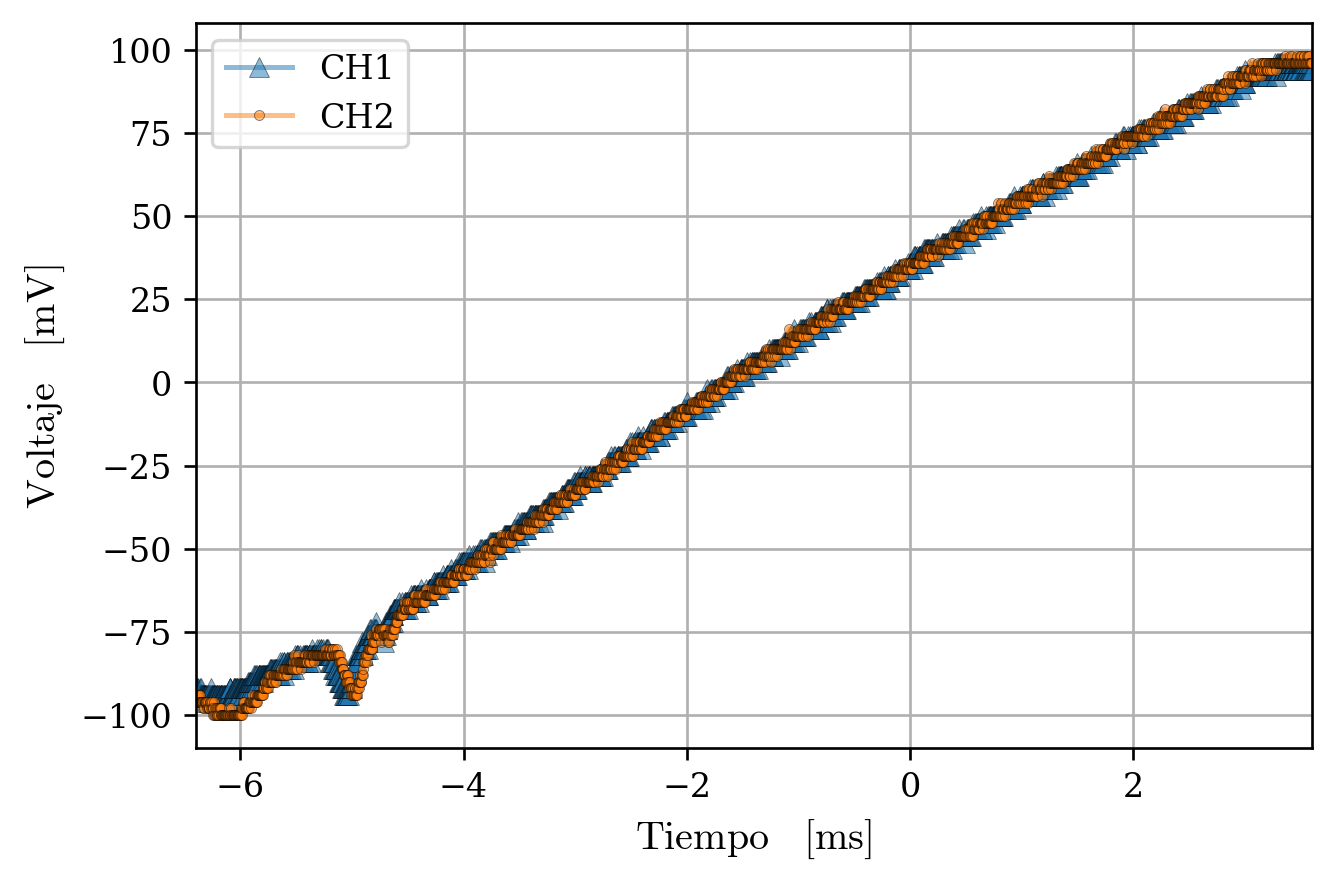

In [68]:
tiempo, channel1 = osci.read_data(0)  # s, V
tiempo, channel2 = osci.read_data(1)  # s, V

plot_channels(tiempo, channel1, channel2, 'mV')
# plt.xlim(-3.3, -1.9)
plt.show()

## Save files:

Columnas: `tiempo [s], voltaje [V], voltaje [V]`

prueba0.npy y prueba1.npy : 
```
        corriente_setpoint = 1.4e-3  # A
        corriente_depth = 0.1/100
        frecuencia del barrido = 50 Hz
        Temperatura = 22.5  # °C : fija
```
 pendiente{i}.npy: 
```
        corriente_setpoint = 1.4e-3  # A
        corriente_depth = 0.1/100
        frecuencia del barrido = 50 Hz
        Temperatura = i×10⁻²  # °C
```

In [69]:
filename = input('Filename: ')+'.npy'
save_osci_data(tiempo, channel1, channel2, filename=filename)

## Load files:

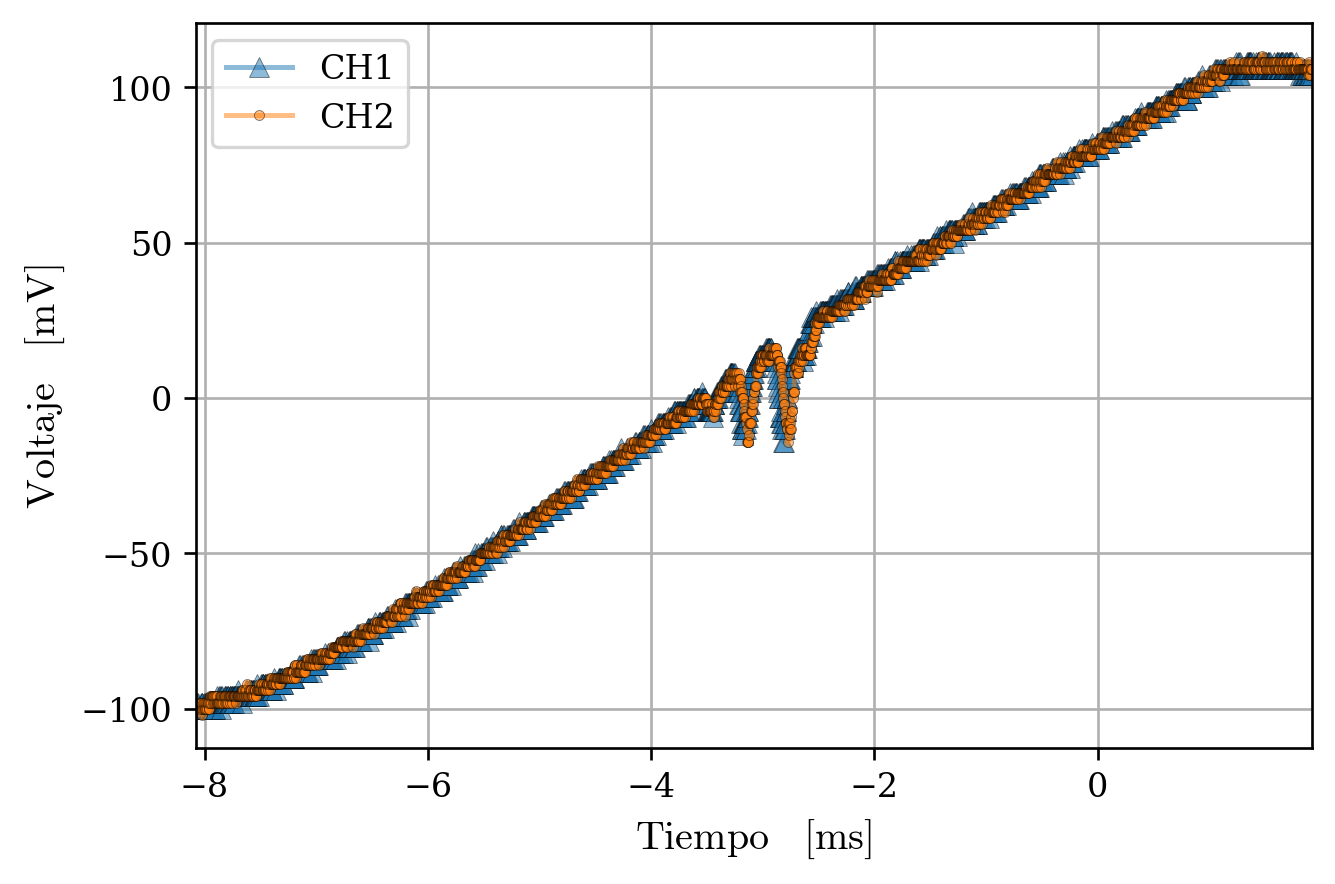

In [10]:
# tiempo, channel1, channel2 = np.load('pendiente0.npy')
plot_channels(tiempo, channel1, channel2, 'mV')

In [78]:
Temps = np.arange(2125, 2375 + 1, 25)  # °C
T = np.zeros((2500, Temps.size))  # s
V1 = np.zeros_like(T)  # V
V2 = np.zeros_like(T)  # V
for i, temp_tag in enumerate(Temps):
    file = f'magnet{temp_tag}.npy'
    T[:, i], V1[:, i], V2[:, i] = np.load(file)



/tmp/ipykernel_9714/1949946242.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(V1)


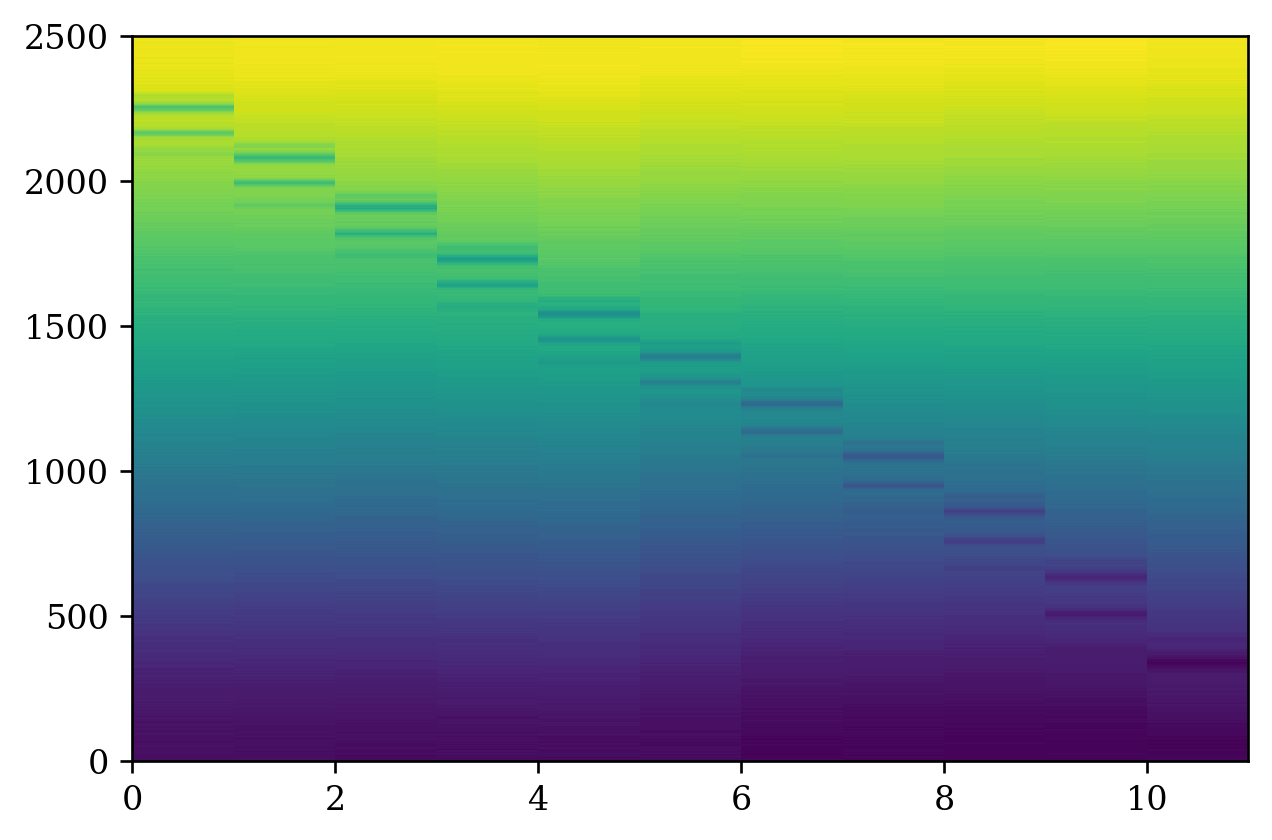

In [79]:
plt.pcolormesh(V1)

/tmp/ipykernel_9714/1949946242.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(V1)


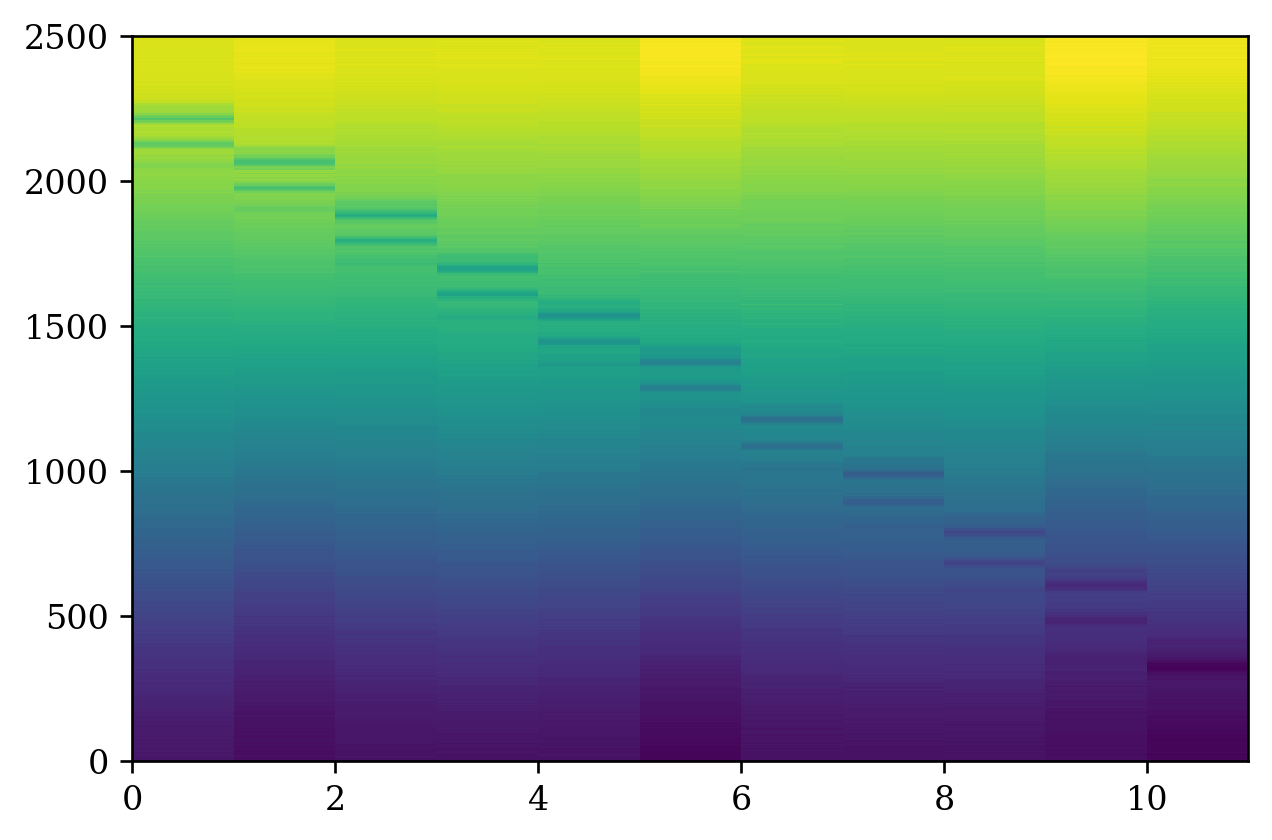

In [77]:
plt.pcolormesh(V1)